- 看数据类型、数量、样例
- 区分类别变量和连续变量
- 看是否有缺失值
- 观察数据分布、不均衡样本
- 探查重要影响因素

In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns
import gc
import datetime
import datetime
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm---*
from itertools import combinations
import lightgbm as lgb
import datatable as dt
from category_encoders import TargetEncoder
import optuna
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
dir_path = '/home/zuoyuhui/datasets/天猫/data_format1/'
file_train = 'train_format1.csv'
file_test = 'test_format1.csv'
file_user_info = 'user_info_format1.csv'
file_user_log = 'user_log_format1.csv'

# 复购率 = 重复购买用户数量/用户样本数量
# 复购率 = 重复购买行为次数(或 交易次数)/用户样本数量

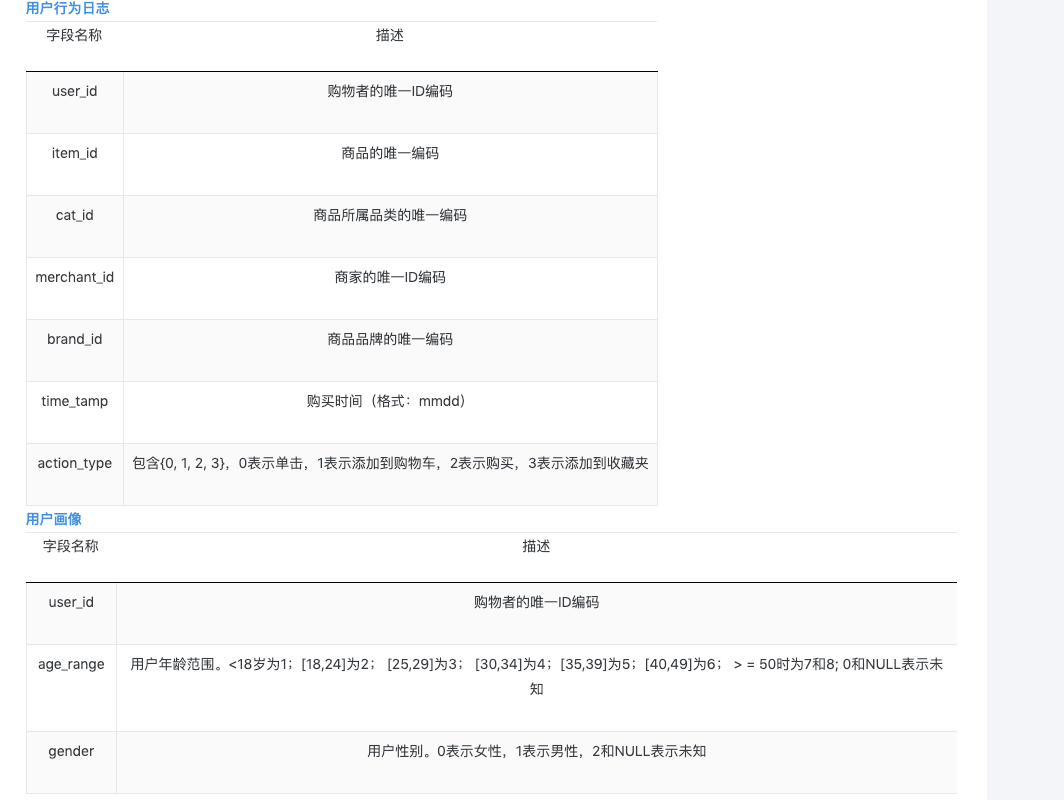

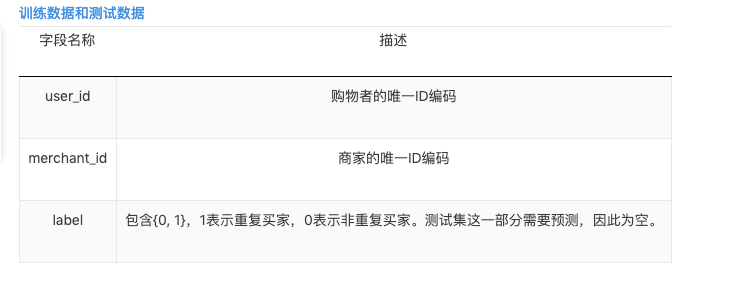

In [5]:
train = pd.read_csv(dir_path+file_train)
train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [6]:
test = pd.read_csv(dir_path+file_test)
test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [7]:
user_info = pd.read_csv(dir_path+file_user_info)
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [8]:
user_log = pd.read_csv(dir_path+file_user_log)
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int64  
 1   merchant_id  261477 non-null  int64  
 2   prob         0 non-null       float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB


In [11]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [12]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


# 缺失值
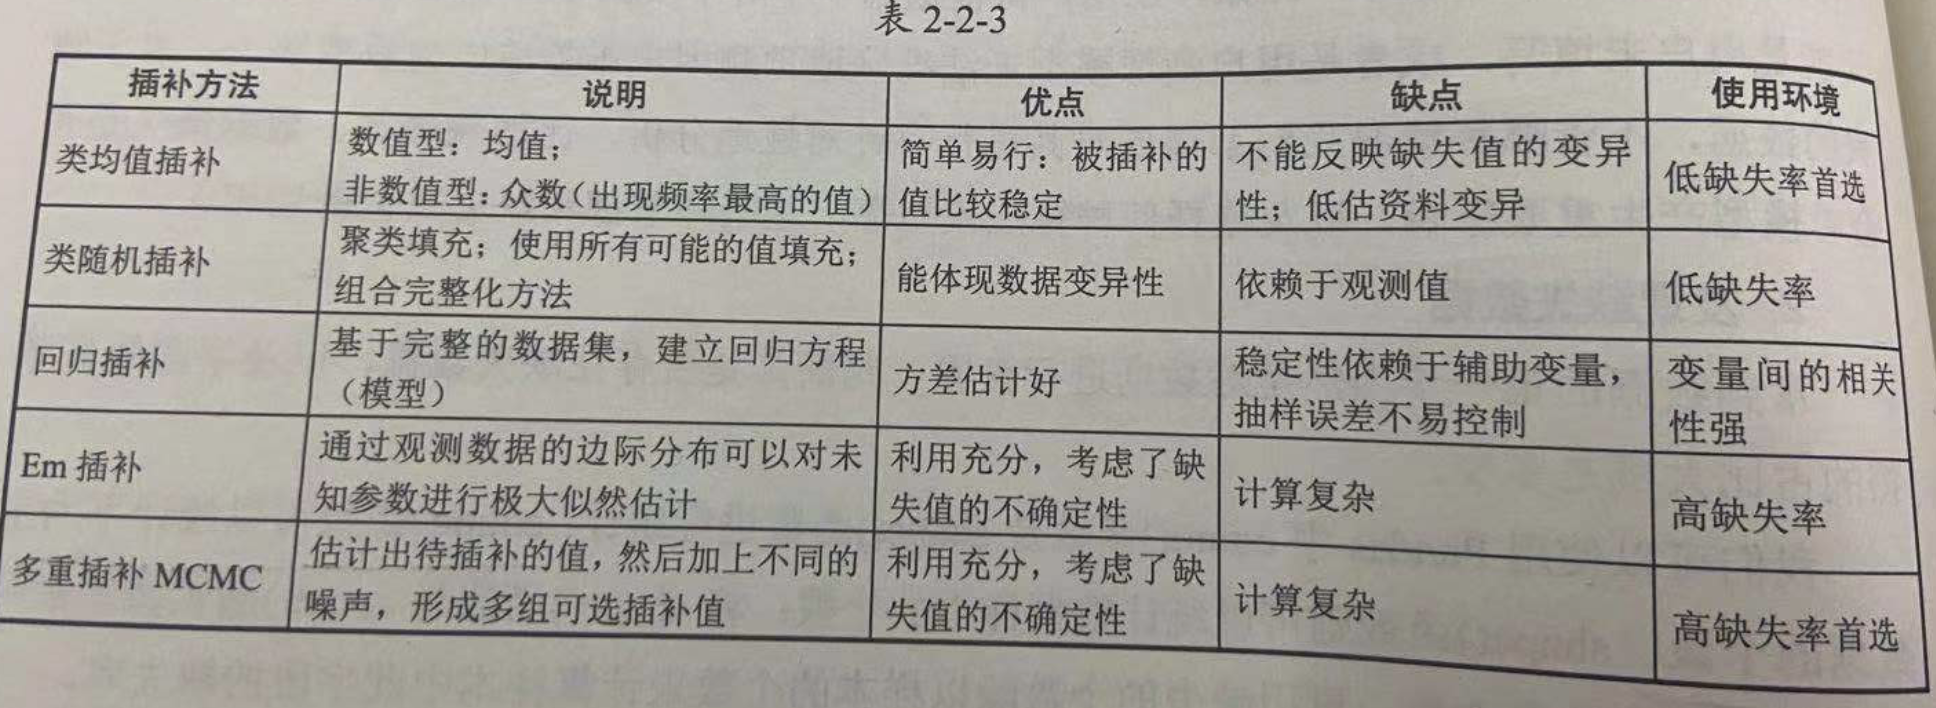

In [15]:
# 有时0代表缺失值，对于缺失值严重的一般删除处理
# 缺失值较少一般三种：
#统计量填充：连续值推荐用中位数，离散值：用众数，不能用均值和中位数
#特殊值填充：正常范围内取值
#不处理：xgb、lgb对缺失值不太敏感，算法本身有一套缺失值处理方法
def missing_value_rate(data,col_name):
    rate_list = {}
    for col in col_name:
        rate = (data.shape[0]-data[col].count())/data.shape[0]
#         na_zero_num = data[data[col].isna() | (data[data[col]==0])].count()
        lable_foamt = 'rate:{}'.format(rate)
        rate_list[col]=lable_foamt
    return rate_list

In [22]:
%time
print('age_range:',user_info[user_info['age_range'].isna() | (user_info['age_range']==0)].count())
print()
print('gender:',user_info[user_info['gender'].isna() | (user_info['gender']==0)].count())
missing_value_rate(user_info,user_info.columns)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 16.5 µs
age_range: user_id      95131
age_range    92914
gender       90664
dtype: int64

gender: user_id      292074
age_range    289879
gender       285638
dtype: int64


{'user_id': 'rate:0.0',
 'age_range': 'rate:0.005226677982884221',
 'gender': 'rate:0.01517316170403376'}

In [24]:
user_info.groupby(['age_range'])['user_id'].count()

age_range
0.0     92914
1.0        24
2.0     52871
3.0    111654
4.0     79991
5.0     40777
6.0     35464
7.0      6992
8.0      1266
Name: user_id, dtype: int64

In [26]:
user_info[user_info['age_range'].isna() | (user_info['age_range']==0) | user_info['gender'].isna() | (user_info['gender']==2)].count() 

user_id      106330
age_range    104113
gender        99894
dtype: int64

In [21]:
print('brand_id:',user_log[user_log['brand_id'].isna() | (user_log['brand_id']==0)].count())
missing_value_rate(user_log,user_log.columns)

brand_id: user_id        91015
item_id        91015
cat_id         91015
seller_id      91015
brand_id           0
time_stamp     91015
action_type    91015
dtype: int64


{'user_id': 'rate:0.0',
 'item_id': 'rate:0.0',
 'cat_id': 'rate:0.0',
 'seller_id': 'rate:0.0',
 'brand_id': 'rate:0.0016570678774255885',
 'time_stamp': 'rate:0.0',
 'action_type': 'rate:0.0'}

In [27]:
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

# 观察数据分布
不均衡样本，可采用
- 随机欠采样
- 随机过采样
- 基于聚类的过采样
- SMOTE算法
- 基于数据清洗的SMOTE

In [28]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476178,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


In [29]:
user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,5.492533e+07,5.492533e+07,5.492533e+07,5.492533e+07,5.483432e+07,5.492533e+07,5.492533e+07
mean,2.121568e+05,5.538613e+05,8.770308e+02,2.470941e+03,4.153348e+03,9.230953e+02,2.854458e-01
std,1.222872e+05,3.221459e+05,4.486269e+02,1.473310e+03,2.397679e+03,1.954305e+02,8.075806e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.110000e+02,0.000000e+00
25%,1.063360e+05,2.731680e+05,5.550000e+02,1.151000e+03,2.027000e+03,7.300000e+02,0.000000e+00
50%,2.126540e+05,5.555290e+05,8.210000e+02,2.459000e+03,4.065000e+03,1.010000e+03,0.000000e+00
75%,3.177500e+05,8.306890e+05,1.252000e+03,3.760000e+03,6.196000e+03,1.109000e+03,0.000000e+00
max,4.241700e+05,1.113166e+06,1.671000e+03,4.995000e+03,8.477000e+03,1.112000e+03,3.000000e+00


In [37]:
# 查看正样本分布 并可视化
label_gp = train.groupby('label')['user_id'].count()
print('正负样本数量:',label_gp)
label_gp[1]

正负样本数量: label
0    244912
1     15952
Name: user_id, dtype: int64


15952

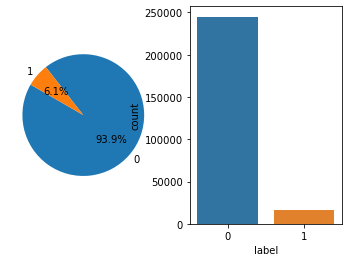

In [45]:
fig = plt.figure()
# 样本分布不均匀 可采用负样本过采样技术，训练多个模型后求平均或者调整模型的损失函数样本比例的权重
ax = plt.subplot(1,2,1)
labels = [0,1]
sizes = [label_gp[0],label_gp[1]]
explode = (0,0)
plt.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',shadow=False,startangle=150)

plt.subplot(1,2,2)
sns.countplot(train['label'])
plt.show()  

In [46]:
#top5销量店铺
train.merchant_id.value_counts().head()

4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64

In [47]:
train_data_merchant = train.copy()
train_data_merchant['TOP5']=train_data_merchant['merchant_id'].map(lambda x:1 if x in [4044,3828,4173,1102,4976] else 0)

In [50]:
train_data_merchant = train_data_merchant[train_data_merchant['TOP5']==1]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


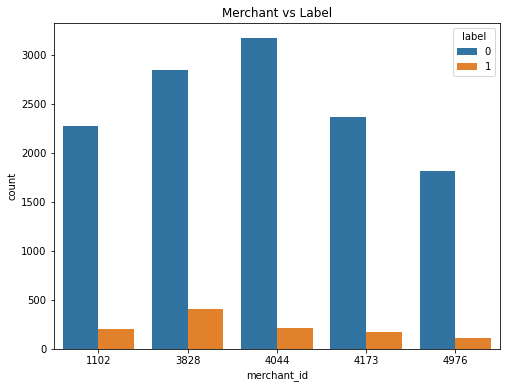

In [53]:
plt.figure(figsize=(8,6))
plt.title('Merchant vs Label')
sax = sns.countplot('merchant_id',hue='label',data=train_data_merchant)

In [55]:
# 查看店铺的复购分布
merchant_repeat_buy = [rate for rate in train.groupby(['merchant_id'])['label'].mean() if rate<=1 and rate>0]

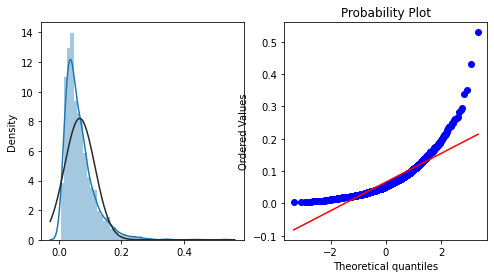

In [60]:
plt.figure(figsize=(8,4))

import scipy.stats as stats
ax = plt.subplot(1,2,1)
sns.distplot(merchant_repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(merchant_repeat_buy,plot=plt)

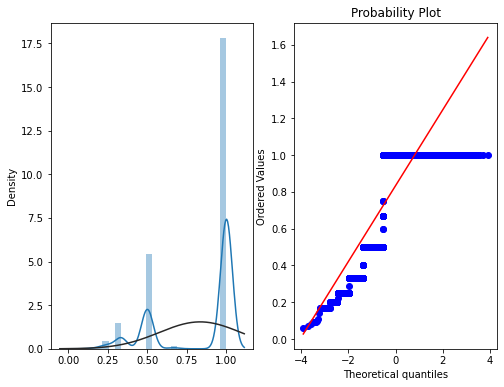

In [63]:
# 对用户分析
user_repeat_buy = [
    rate for rate in train.groupby(['user_id'])['label'].mean()
    if rate <=1 and rate>0
]

plt.figure(figsize=(8,6))
ax = plt.subplot(1,2,1)
sns.distplot(user_repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(user_repeat_buy,plot=plt)

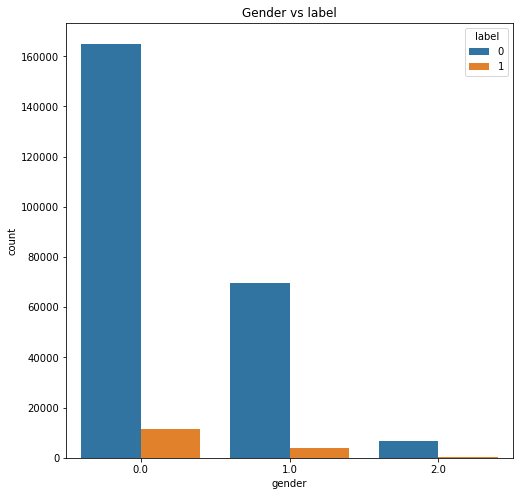

In [66]:
# 用户性别分析
train_user_info =train.merge(user_info,on=['user_id'],how='left')

plt.figure(figsize=(8,8))
plt.title('Gender vs label')
ax = sns.countplot('gender',hue='label',data=train_user_info)
for p in ax.patches:
    height = p.get_height()

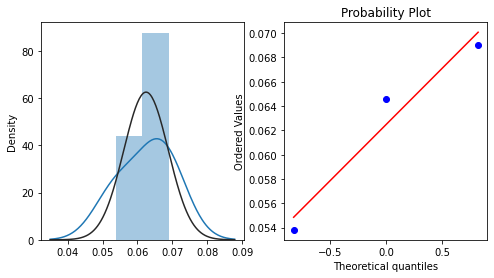

In [69]:
# 不同性别对用户的复购率不同
repeat_buy = [rate for rate in train_user_info.groupby(['gender'])['label'].mean()]

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
sns.distplot(repeat_buy,fit=stats.norm)

ax = plt.subplot(1,2,2)
res = stats.probplot(repeat_buy,plot=plt) 
# 它主要是直观的表示观测与预测值之间的差异。一般我们所取得数量性状数据都为正态分布数据。预测的线是一条从原点出发的45度角的虚线，事件观测值是实心点。
# 偏离线越大，则两个数据集来自具有不同分布的群体的结论的证据就越大。

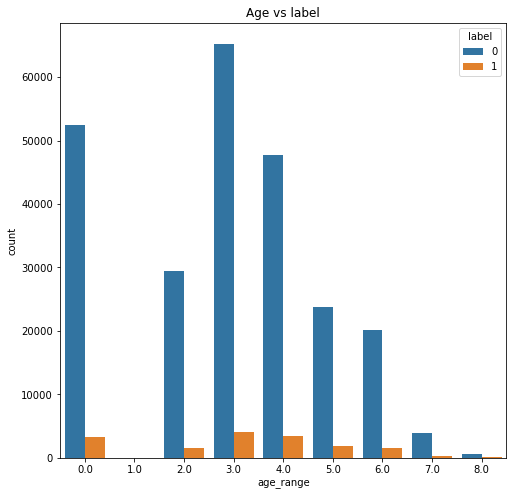

In [71]:
# 对用户年龄分析
plt.figure(figsize=(8,8))
plt.title('Age vs label')
ax = sns.countplot('age_range',hue='label',data = train_user_info)

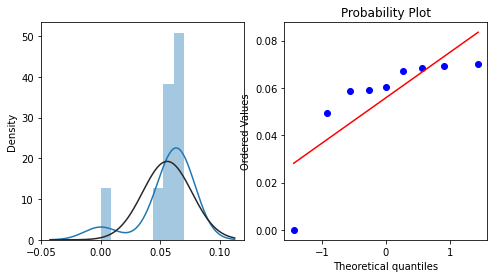

In [74]:
# 用户年龄复购的分布
# 不同年龄段对用户的复购率不同
repeat_buy = [rate for rate in train_user_info.groupby(['age_range'])['label'].mean()]

plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)
sns.distplot(repeat_buy,fit=stats.norm)
ax = plt.subplot(1,2,2)
res = stats.probplot(repeat_buy,plot=plt)